In [1]:
%load_ext autoreload
%autoreload 2

import os
if os.getcwd() == '/home/jovyan/work': # jhub
    os.chdir("24FS_I4DS27/main/") 
    os.system("make reqs")
else: # local
    os.chdir("../")

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

In [3]:
# read in the results
results = defaultdict(list)
for folder in os.listdir("robustified_models"):

    folder_split = folder.split("-")
    model = f"{folder_split[0]}-{folder_split[1]}-{folder_split[2]}"
    i = folder_split[3].split("_")[1]

    for subfolder in os.listdir(f"robustified_models/{folder}"):
        if subfolder == "01_UAPs_pre_robustification":
            if os.path.exists(f"robustified_models/{folder}/{subfolder}/UAPs_tensor.pt"):
                csv_file = f"robustified_models/{folder}/{subfolder}/metrics.csv"
                metrics_df = pd.read_csv(csv_file)
                uap_time_elapsed = metrics_df["uap_time_elapsed"].dropna()
                results[(model, i, subfolder, "uap_time_elapsed", "mean")] = uap_time_elapsed.mean()
                results[(model, i, subfolder, "uap_time_elapsed", "std")] = uap_time_elapsed.std()
            else:
                results[(model, i, subfolder, "uap_time_elapsed", "mean")] = np.inf
                results[(model, i, subfolder, "uap_time_elapsed", "std")] = np.inf

        if subfolder.startswith(("02", "03", "05", "06")):
            csv_file = f"robustified_models/{folder}/{subfolder}/metrics.csv"
            metrics_df = pd.read_csv(csv_file).iloc[:, 2:]
            for col in metrics_df.columns:
                results[(model, i, subfolder, col, None)] = metrics_df.loc[:, col].values[0]

        if subfolder.startswith(("03", "06")):
            no_perturbations_foldername = (
                "02_eval_unrobustified_test" if subfolder.startswith("03") else "05_eval_robustified_test"
            )
            predictions_UAP_df = pd.read_csv(f"robustified_models/{folder}/{subfolder}/test_predictions.csv")
            predictions_df = pd.read_csv(
                f"robustified_models/{folder}/{no_perturbations_foldername}/test_predictions.csv"
            )

            results[(model, i, subfolder, "fooling_rate", None)] = (
                predictions_UAP_df.predictions.round() != predictions_df.predictions.round()
            ).mean()
            # results[(model, i, subfolder, "predictions", None)] = list(predictions_df.iloc[:, 1].values)
            # results[(model, i, subfolder, "targets", None)] = list(predictions_df.iloc[:, 2].values.astype(int))

        if subfolder.startswith("04"):
            csv_file = f"robustified_models/{folder}/{subfolder}/metrics.csv"
            metrics_df = pd.read_csv(csv_file).iloc[:, 9:]
            for col in metrics_df.columns:
                results[(model, i, subfolder, col, None)] = metrics_df.loc[:, col].dropna().values

df_results = pd.DataFrame.from_dict(
    results,
    orient="index",
    columns=["value"],
)
df_results.index = pd.MultiIndex.from_tuples(
    df_results.index,
    names=["model", "robustification", "stage", "metric", "agg"],
)
df_results = df_results.sort_values(
    by=["model", "robustification", "stage", "metric", "agg"],
)
df_results = df_results.reset_index()

In [4]:
fooling_rates = df_results[df_results["metric"] == "fooling_rate"].sort_values(
    by=["robustification", "stage"], ascending=True
)

fooling_rates_unrobustified = (
    fooling_rates[fooling_rates["stage"].str.startswith("03")]
    .groupby(["model", "robustification"])["value"]
    .agg(["mean", "sem"])
)
fooling_rates_unrobustified_mean = fooling_rates_unrobustified.pivot_table(
    index="model", columns="robustification", values="mean"
)
fooling_rates_unrobustified_sem = fooling_rates_unrobustified.pivot_table(
    index="model", columns="robustification", values="sem"
)

fooling_rates_robustified = (
    fooling_rates[fooling_rates["stage"].str.startswith("06")]
    .groupby(["model", "robustification"])["value"]
    .agg(["mean", "sem"])
)
fooling_rates_robustified_mean = fooling_rates_robustified.pivot_table(
    index="model", columns="robustification", values="mean"
)
fooling_rates_robustified_sem = fooling_rates_robustified.pivot_table(
    index="model", columns="robustification", values="sem"
)

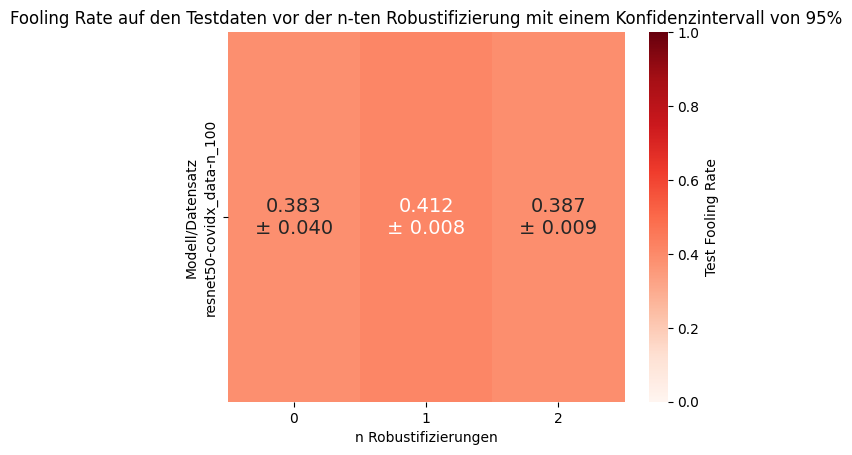

In [5]:
annot = np.empty_like(fooling_rates_unrobustified_mean.values, dtype=object)
for i in range(fooling_rates_unrobustified_mean.shape[0]):
    for j in range(fooling_rates_unrobustified_mean.shape[1]):
        annot[i, j] = f"{fooling_rates_unrobustified_mean.values[i, j]:.3f}\n± {1.96 * fooling_rates_unrobustified_sem.values[i, j]:.3f}"

sns.heatmap(
    fooling_rates_unrobustified_mean.astype(float),
    annot=annot,
    fmt="",
    cmap="Reds",
    cbar_kws={"label": "Test Fooling Rate"},
    annot_kws={"size": 14},
    vmin=0,
    vmax=1,
)

plt.xlabel("n Robustifizierungen")
plt.ylabel("Modell/Datensatz")
plt.title("Fooling Rate auf den Testdaten vor der n-ten Robustifizierung mit einem Konfidenzintervall von 95%")
plt.show()

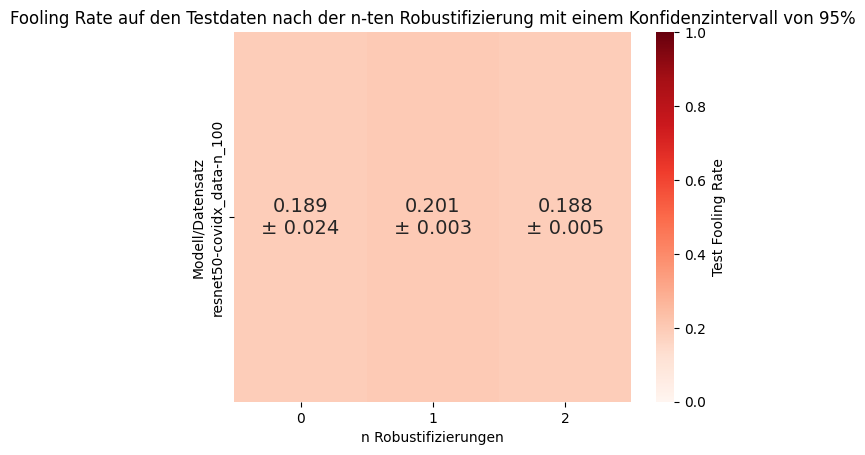

In [6]:
annot = np.empty_like(fooling_rates_robustified_mean.values, dtype=object)
for i in range(fooling_rates_robustified_mean.shape[0]):
    for j in range(fooling_rates_robustified_mean.shape[1]):
        annot[i, j] = (
            f"{fooling_rates_robustified_mean.values[i, j]:.3f}\n± {1.96 * fooling_rates_robustified_sem.values[i, j]:.3f}"
        )

sns.heatmap(
    fooling_rates_robustified_mean.astype(float),
    annot=annot,
    fmt="",
    cmap="Reds",
    cbar_kws={"label": "Test Fooling Rate"},
    annot_kws={"size": 14},
    vmin=0,
    vmax=1,
)

plt.xlabel("n Robustifizierungen")
plt.ylabel("Modell/Datensatz")
plt.title("Fooling Rate auf den Testdaten nach der n-ten Robustifizierung mit einem Konfidenzintervall von 95%")
plt.show()